Aircraft Slot Scheduling

In [1]:
import pulp
import pandas as pd

# 1. Load flight dataset
df = pd.read_csv("flights.csv")

# 2. Define time slots for the 1-hour window (0–59 minutes)
slots = list(range(0, 60))

# 3. Create LP model
model = pulp.LpProblem("Runway_Slot_Optimization", pulp.LpMinimize)

# 4. Decision variables x[(i,j)] = 1 if flight i is assigned to slot j
x = {}
for i in df.index:
    for j in slots:
        # Only create variables for slots within [Early, Late]
        if df.loc[i, "Early"] <= j <= df.loc[i, "Late"]:
            x[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", cat="Binary")

# 5. Objective function: minimize total delay cost
# delay = max(0, assigned_slot - scheduled_time)
# cost_ij = delay * Cost * priority_weight
priority_weight = {1: 1.5, 2: 1.2, 3: 1.0}

objective_terms = []
for (i, j), var in x.items():
    row = df.loc[i]
    delay = max(0, j - row["Scheduled"])
    weight = priority_weight[row["Priority"]]
    cost_ij = delay * row["Cost"] * weight
    objective_terms.append(cost_ij * var)

model += pulp.lpSum(objective_terms)

# 6. Constraint: each flight gets exactly ONE slot
for i in df.index:
    valid_slots = [x[(i, j)] for j in slots if (i, j) in x]
    model += pulp.lpSum(valid_slots) == 1, f"OneSlot_Flight_{i}"

# 7. Constraint: at most one flight per slot (single runway)
for j in slots:
    vars_in_slot = [x[(i, j)] for i in df.index if (i, j) in x]
    if vars_in_slot:
        model += pulp.lpSum(vars_in_slot) <= 1, f"OneFlight_Per_Slot_{j}"

# 8. Separation constraints
# If flight i is at slot j, no other flight k can be in [j+1 ... j+Gap_i]
for i in df.index:
    gap_i = int(df.loc[i, "Gap"])
    for k in df.index:
        if i == k:
            continue
        for j in slots:
            if (i, j) in x:
                for sep in range(1, gap_i + 1):
                    j2 = j + sep
                    if j2 in slots and (k, j2) in x:
                        model += x[(i, j)] + x[(k, j2)] <= 1, f"Sep_{i}_{k}_{j}_{j2}"

# 9. Solve
model.solve(pulp.PULP_CBC_CMD(msg=1))

print("Status:", pulp.LpStatus[model.status])

# 10. Extract and display solution
assignments = []
for (i, j), var in x.items():
    if var.value() == 1:
        row = df.loc[i]
        delay = j - row["Scheduled"]
        assignments.append({
            "Flight_ID": row["Flight_ID"],
            "Type": row["Type"],
            "Scheduled": row["Scheduled"],
            "Assigned_Slot": j,
            "Delay_Min": delay,
            "Priority": row["Priority"]
        })

result_df = pd.DataFrame(assignments).sort_values(by="Assigned_Slot")
print(result_df)

Status: Optimal
   Flight_ID     Type  Scheduled  Assigned_Slot  Delay_Min  Priority
0      AI101  Landing          5              0         -5         1
1      6E202  Takeoff          8              3         -5         2
2      UK301  Landing         12              6         -6         3
3     VTI404  Takeoff         15             10         -5         2
5      AI106  Landing         20             12         -8         1
4      G8205  Landing         18             16         -2         2
7      UK310  Landing         25             19         -6         2
6      6E209  Takeoff         22             22          0         3
9      AI112  Landing         30             24         -6         1
8      G8210  Takeoff         28             28          0         2
11     UK318  Landing         35             30         -5         2
10     6E215  Takeoff         33             33          0         3
12     G8218  Takeoff         38             35         -3         2
14     6E223  Take

Status: Optimal
   Flight_ID     Type  Scheduled  Assigned_Slot  Delay_Min  Priority
0      AI101  Landing          5              0         -5         1
1      6E202  Takeoff          8              3         -5         2
2      UK301  Landing         12              6         -6         3
3     VTI404  Takeoff         15             10         -5         2
5      AI106  Landing         20             12         -8         1
4      G8205  Landing         18             16         -2         2
7      UK310  Landing         25             19         -6         2
6      6E209  Takeoff         22             22          0         3
9      AI112  Landing         30             24         -6         1
8      G8210  Takeoff         28             28          0         2
11     UK318  Landing         35             30         -5         2
10     6E215  Takeoff         33             33          0         3
12     G8218  Takeoff         38             35         -3         2
14     6E223  Take

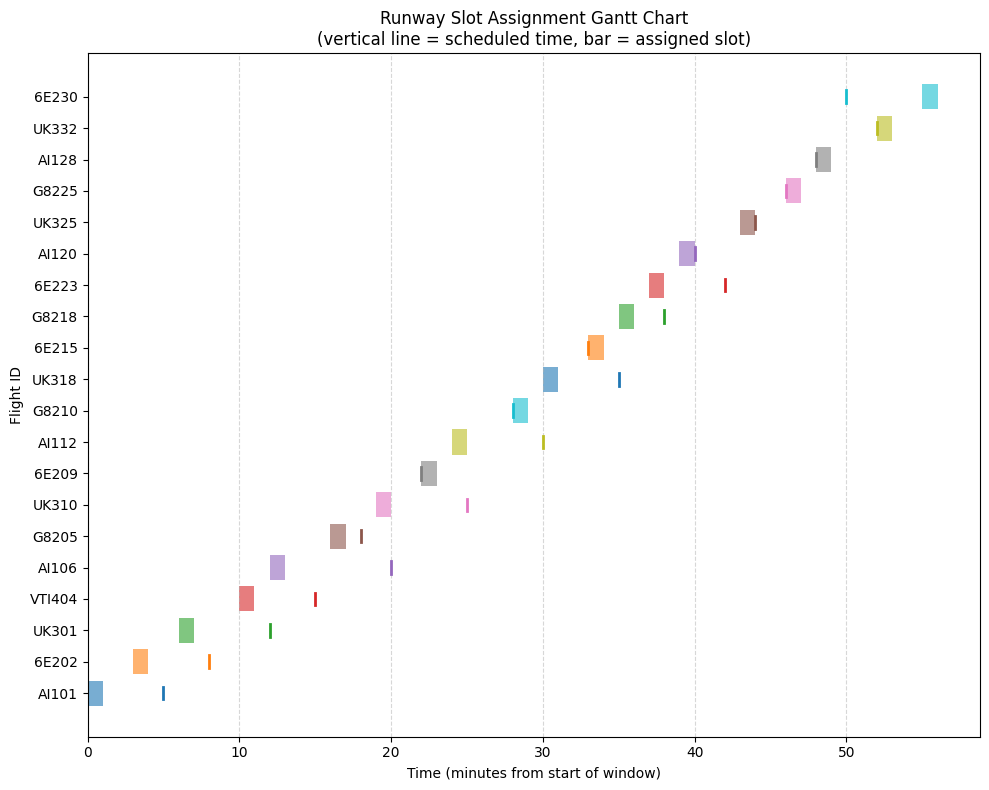

In [3]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load flight dataset
df = pd.read_csv("flights.csv")

# 2. Define time slots for the 1-hour window (0–59 minutes)
slots = list(range(0, 60))

# 3. Create LP model
model = pulp.LpProblem("Runway_Slot_Optimization", pulp.LpMinimize)

# 4. Decision variables x[(i,j)] = 1 if flight i is assigned to slot j
x = {}
for i in df.index:
    for j in slots:
        # Only create variables for slots within [Early, Late]
        if df.loc[i, "Early"] <= j <= df.loc[i, "Late"]:
            x[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", cat="Binary")

# 5. Objective function: minimize total delay cost
priority_weight = {1: 1.5, 2: 1.2, 3: 1.0}

objective_terms = []
for (i, j), var in x.items():
    row = df.loc[i]
    delay = max(0, j - row["Scheduled"])
    weight = priority_weight[row["Priority"]]
    cost_ij = delay * row["Cost"] * weight
    objective_terms.append(cost_ij * var)

model += pulp.lpSum(objective_terms)

# 6. Constraint: each flight gets exactly ONE slot
for i in df.index:
    valid_slots = [x[(i, j)] for j in slots if (i, j) in x]
    model += pulp.lpSum(valid_slots) == 1, f"OneSlot_Flight_{i}"

# 7. Constraint: at most one flight per slot (single runway)
for j in slots:
    vars_in_slot = [x[(i, j)] for i in df.index if (i, j) in x]
    if vars_in_slot:
        model += pulp.lpSum(vars_in_slot) <= 1, f"OneFlight_Per_Slot_{j}"

# 8. Separation constraints
for i in df.index:
    gap_i = int(df.loc[i, "Gap"])
    for k in df.index:
        if i == k:
            continue
        for j in slots:
            if (i, j) in x:
                for sep in range(1, gap_i + 1):
                    j2 = j + sep
                    if j2 in slots and (k, j2) in x:
                        model += x[(i, j)] + x[(k, j2)] <= 1, f"Sep_{i}_{k}_{j}_{j2}"

# 9. Solve
model.solve(pulp.PULP_CBC_CMD(msg=1))

print("Status:", pulp.LpStatus[model.status])

# 10. Extract and display solution
assignments = []
for (i, j), var in x.items():
    if var.value() == 1:
        row = df.loc[i]
        delay = j - row["Scheduled"]
        assignments.append({
            "Flight_ID": row["Flight_ID"],
            "Type": row["Type"],
            "Scheduled": row["Scheduled"],
            "Assigned_Slot": j,
            "Delay_Min": delay,
            "Priority": row["Priority"]
        })

result_df = pd.DataFrame(assignments).sort_values(by="Assigned_Slot")
print(result_df)

# 11. Gantt-style chart of assigned slots vs scheduled times
plt.figure(figsize=(10, 8))

# We'll plot each flight on its own y-position
y_positions = range(len(result_df))
flight_ids = result_df["Flight_ID"].tolist()

for idx, (_, row) in enumerate(result_df.iterrows()):
    y = y_positions[idx]
    scheduled = row["Scheduled"]
    assigned = row["Assigned_Slot"]

    # Plot scheduled time as a vertical marker (small line)
    plt.plot([scheduled, scheduled], [y - 0.2, y + 0.2], linewidth=2)

    # Plot assigned slot as a horizontal bar (length 1 minute)
    plt.barh(y, 1, left=assigned, alpha=0.6)

# Formatting
plt.yticks(y_positions, flight_ids)
plt.xlabel("Time (minutes from start of window)")
plt.ylabel("Flight ID")
plt.title("Runway Slot Assignment Gantt Chart\n(vertical line = scheduled time, bar = assigned slot)")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [6]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt

# ================================
# 1. Load congested 40-flight data
# ================================
df = pd.read_csv("flights_2.csv")

# Time window: 0–59 minutes
slots = list(range(0, 90))

# ================================
# 2. Define the optimization model
# ================================
model = pulp.LpProblem("Runway_Slot_Optimization_40_Flights", pulp.LpMinimize)

# ================================
# 3. Decision variables x[(i,j)]
#    = 1 if flight i assigned to slot j
# ================================
x = {}
for i in df.index:
    for j in slots:
        # only create variables if slot is within [Early, Late] window
        if df.loc[i, "Early"] <= j <= df.loc[i, "Late"]:
            x[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", cat="Binary")

# ================================
# 4. Objective function: Minimize total delay cost
#    delay_ij = max(0, j - Scheduled_i)
#    cost_ij = delay_ij * Cost_i * priority_weight[Priority_i]
# ================================
priority_weight = {1: 1.5, 2: 1.2, 3: 1.0}

objective_terms = []
for (i, j), var in x.items():
    row = df.loc[i]
    delay = max(0, j - row["Scheduled"])
    weight = priority_weight[row["Priority"]]
    cost_ij = delay * row["Cost"] * weight
    objective_terms.append(cost_ij * var)

model += pulp.lpSum(objective_terms), "Total_Delay_Cost"

# ================================
# 5. Each flight must get exactly ONE slot
# ================================
for i in df.index:
    valid_slots = [x[(i, j)] for j in slots if (i, j) in x]
    model += pulp.lpSum(valid_slots) == 1, f"OneSlot_Flight_{i}"

# ================================
# 6. At most one flight per slot (single runway)
# ================================
for j in slots:
    vars_in_slot = [x[(i, j)] for i in df.index if (i, j) in x]
    if vars_in_slot:  # only add if at least one variable exists for that slot
        model += pulp.lpSum(vars_in_slot) <= 1, f"OneFlight_Per_Slot_{j}"

# ================================
# 7. Separation constraints
#    If flight i is at slot j, no flight k can be in [j+1 ... j+Gap_i]
# ================================
for i in df.index:
    gap_i = int(df.loc[i, "Gap"])
    for k in df.index:
        if i == k:
            continue
        for j in slots:
            if (i, j) in x:
                for sep in range(1, gap_i + 1):
                    j2 = j + sep
                    if j2 in slots and (k, j2) in x:
                        model += x[(i, j)] + x[(k, j2)] <= 1, f"Sep_{i}_{k}_{j}_{j2}"

# ================================
# 8. Solve the model
# ================================
solver = pulp.PULP_CBC_CMD(msg=1)
model.solve(solver)

print("Status:", pulp.LpStatus[model.status])
print("Objective value (Total Delay Cost):", pulp.value(model.objective))

# ================================
# 9. Extract solution
# ================================
assignments = []
for (i, j), var in x.items():
    if var.value() == 1:
        row = df.loc[i]
        delay = j - row["Scheduled"]
        assignments.append({
            "Flight_ID": row["Flight_ID"],
            "Airline": row["Airline"],
            "Type": row["Type"],
            "Scheduled": row["Scheduled"],
            "Assigned_Slot": j,
            "Delay_Min": delay,
            "Priority": row["Priority"],
            "Size": row["Size"]
        })

result_df = pd.DataFrame(assignments).sort_values(by="Assigned_Slot")
print("\nAssigned Slots:")
print(result_df)

# ================================
# 10. Gantt-style chart
# ================================
plt.figure(figsize=(12, 10))

y_positions = range(len(result_df))
flight_ids = result_df["Flight_ID"].tolist()

# Optional: color by priority
priority_colors = {
    1: "tab:red",    # high
    2: "tab:orange", # medium
    3: "tab:blue"    # low
}

for idx, (_, row) in enumerate(result_df.iterrows()):
    y = y_positions[idx]
    scheduled = row["Scheduled"]
    assigned = row["Assigned_Slot"]
    priority = row["Priority"]

    # scheduled time as vertical line
    plt.plot([scheduled, scheduled], [y - 0.3, y + 0.3], linewidth=2, color="black")

    # assigned slot as bar (1-minute width)
    plt.barh(
        y,
        1,                  # width of bar = 1 minute
        left=assigned,
        alpha=0.7,
        color=priority_colors.get(priority, "gray"),
        edgecolor="k"
    )

# Formatting
plt.yticks(y_positions, flight_ids)
plt.xlabel("Time (minutes from start of window)")
plt.ylabel("Flight ID")
plt.title("Runway Slot Assignment - 40 Flight Congested Scenario\n"
          "Vertical line = Scheduled time, Colored bar = Assigned slot (color = priority)")

plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

Status: Infeasible
Objective value (Total Delay Cost): 0.0


KeyError: 'Assigned_Slot'

In [11]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load flight dataset
df = pd.read_csv("flights_2.csv")

# 2. Define time slots for the 1-hour window (0–59 minutes)
# If you want to relax constraints later, change 60 to 90 or 120.
slots = list(range(0, 300))

# 3. Create LP model
model = pulp.LpProblem("Runway_Slot_Optimization", pulp.LpMinimize)

# 4. Decision variables x[(i,j)] = 1 if flight i is assigned to slot j
x = {}
for i in df.index:
    for j in slots:
        # Only create variables for slots within [Early, Late]
        if df.loc[i, "Early"] <= j <= df.loc[i, "Late"]:
            x[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", cat="Binary")

# 5. Objective function: minimize total delay cost
priority_weight = {1: 1.5, 2: 1.2, 3: 1.0}

objective_terms = []
for (i, j), var in x.items():
    row = df.loc[i]
    delay = max(0, j - row["Scheduled"])
    weight = priority_weight[row["Priority"]]
    cost_ij = delay * row["Cost"] * weight
    objective_terms.append(cost_ij * var)

model += pulp.lpSum(objective_terms), "Total_Delay_Cost"

# 6. Constraint: each flight gets exactly ONE slot
for i in df.index:
    valid_slots = [x[(i, j)] for j in slots if (i, j) in x]
    # If there are no valid slots for this flight (bad Early/Late), this will force infeasibility.
    model += pulp.lpSum(valid_slots) == 1, f"OneSlot_Flight_{i}"

# 7. Constraint: at most one flight per slot (single runway)
for j in slots:
    vars_in_slot = [x[(i, j)] for i in df.index if (i, j) in x]
    if vars_in_slot:
        model += pulp.lpSum(vars_in_slot) <= 1, f"OneFlight_Per_Slot_{j}"

# 8. Separation constraints
for i in df.index:
    gap_i = int(df.loc[i, "Gap"])  # you can reduce this (e.g. max(gap_i-1,1)) if infeasible
    for k in df.index:
        if i == k:
            continue
        for j in slots:
            if (i, j) in x:
                for sep in range(1, gap_i + 1):
                    j2 = j + sep
                    if j2 in slots and (k, j2) in x:
                        model += x[(i, j)] + x[(k, j2)] <= 1, f"Sep_{i}_{k}_{j}_{j2}"

# 9. Solve
solver = pulp.PULP_CBC_CMD(msg=1)
model.solve(solver)

status = pulp.LpStatus[model.status]
print("Status:", status)

if status == "Optimal":
    print("Objective value (Total Delay Cost):", pulp.value(model.objective))
else:
    print("No feasible optimal solution found. "
          "Try increasing the time window, relaxing Gap, or widening Early/Late ranges.")

# 10. Extract and display solution (only if optimal)
assignments = []

if status == "Optimal":
    for (i, j), var in x.items():
        if var.value() == 1:
            row = df.loc[i]
            delay = j - row["Scheduled"]
            assignments.append({
                "Flight_ID": row["Flight_ID"],
                "Type": row["Type"],
                "Scheduled": row["Scheduled"],
                "Assigned_Slot": j,
                "Delay_Min": delay,
                "Priority": row["Priority"]
            })

    result_df = pd.DataFrame(assignments).sort_values(by="Assigned_Slot")
    print(result_df)

    # 11. Gantt-style chart of assigned slots vs scheduled times (only if we have data)
    if not result_df.empty:
        plt.figure(figsize=(10, 8))

        # We'll plot each flight on its own y-position
        y_positions = range(len(result_df))
        flight_ids = result_df["Flight_ID"].tolist()

        # Optional: color by priority
        priority_colors = {
            1: "tab:red",    # high
            2: "tab:orange", # medium
            3: "tab:blue"    # low
        }

        for idx, (_, row) in enumerate(result_df.iterrows()):
            y = y_positions[idx]
            scheduled = row["Scheduled"]
            assigned = row["Assigned_Slot"]
            pri = row["Priority"]

            # Plot scheduled time as a vertical marker (small black line)
            plt.plot([scheduled, scheduled], [y - 0.2, y + 0.2], linewidth=2, color="black")

            # Plot assigned slot as a horizontal bar (length 1 minute)
            plt.barh(
                y,
                1,  # width in minutes
                left=assigned,
                alpha=0.6,
                color=priority_colors.get(pri, "gray"),
                edgecolor="k"
            )

        # Formatting
        plt.yticks(y_positions, flight_ids)
        plt.xlabel("Time (minutes from start of window)")
        plt.ylabel("Flight ID")
        plt.title("Runway Slot Assignment Gantt Chart\n"
                  "Vertical line = scheduled time, colored bar = assigned slot (by priority)")
        plt.grid(axis="x", linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()
else:
    # No Gantt chart if not optimal
    pass


Status: Infeasible
No feasible optimal solution found. Try increasing the time window, relaxing Gap, or widening Early/Late ranges.


Flight index 0, ID AI201 has 16 valid slots
Flight index 1, ID 6E310 has 17 valid slots
Flight index 2, ID UK410 has 18 valid slots
Flight index 3, ID G8305 has 19 valid slots
Flight index 4, ID SG501 has 20 valid slots
Flight index 5, ID AI203 has 20 valid slots
Flight index 6, ID I5201 has 21 valid slots
Flight index 7, ID 6E312 has 21 valid slots
Flight index 8, ID UK412 has 21 valid slots
Flight index 9, ID G8307 has 21 valid slots
Flight index 10, ID SG503 has 21 valid slots
Flight index 11, ID AI205 has 21 valid slots
Flight index 12, ID QP101 has 21 valid slots
Flight index 13, ID 6E314 has 21 valid slots
Flight index 14, ID UK414 has 21 valid slots
Flight index 15, ID G8309 has 21 valid slots
Flight index 16, ID SG505 has 21 valid slots
Flight index 17, ID AI207 has 21 valid slots
Flight index 18, ID I5203 has 21 valid slots
Flight index 19, ID 6E316 has 21 valid slots
Flight index 20, ID UK416 has 21 valid slots
Flight index 21, ID G8311 has 21 valid slots
Flight index 22, ID 

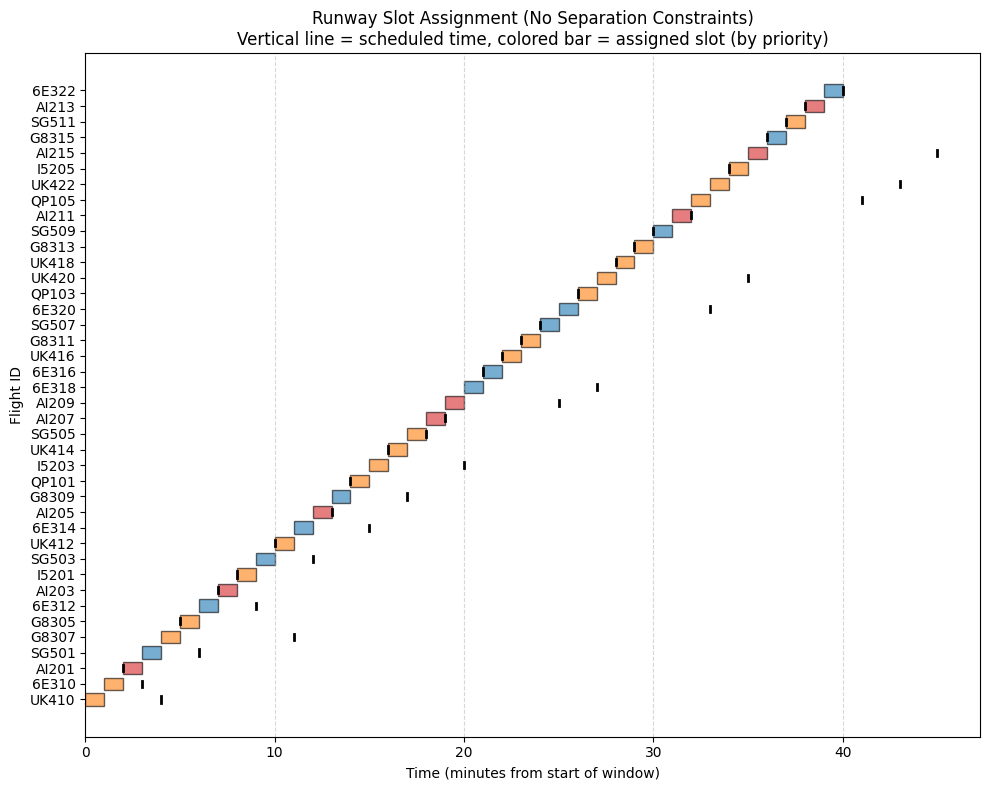

In [10]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load flight dataset
df = pd.read_csv("flights_2.csv")

# 2. Define time slots for the 1-hour window (0–59 minutes)
slots = list(range(0, 300))

# 3. Create LP model
model = pulp.LpProblem("Runway_Slot_Optimization", pulp.LpMinimize)

# 4. Decision variables x[(i,j)] = 1 if flight i is assigned to slot j
x = {}
for i in df.index:
    for j in slots:
        if df.loc[i, "Early"] <= j <= df.loc[i, "Late"]:
            x[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", cat="Binary")

# 5. Objective function: minimize total delay cost
priority_weight = {1: 1.5, 2: 1.2, 3: 1.0}
objective_terms = []

for (i, j), var in x.items():
    row = df.loc[i]
    delay = max(0, j - row["Scheduled"])
    weight = priority_weight[row["Priority"]]
    cost_ij = delay * row["Cost"] * weight
    objective_terms.append(cost_ij * var)

model += pulp.lpSum(objective_terms), "Total_Delay_Cost"

# 6. Constraint: each flight gets exactly ONE slot
for i in df.index:
    valid_slots = [x[(i, j)] for j in slots if (i, j) in x]
    print(f"Flight index {i}, ID {df.loc[i,'Flight_ID']} has {len(valid_slots)} valid slots")
    model += pulp.lpSum(valid_slots) == 1, f"OneSlot_Flight_{i}"

# 7. Constraint: at most one flight per slot (single runway)
for j in slots:
    vars_in_slot = [x[(i, j)] for i in df.index if (i, j) in x]
    if vars_in_slot:
        model += pulp.lpSum(vars_in_slot) <= 1, f"OneFlight_Per_Slot_{j}"

# 8. Solve
solver = pulp.PULP_CBC_CMD(msg=1)
model.solve(solver)

status = pulp.LpStatus[model.status]
print("Status:", status)

if status == "Optimal":
    print("Objective value (Total Delay Cost):", pulp.value(model.objective))
else:
    print("No feasible solution — check valid slots per flight above.")

# 9. Extract solution
assignments = []

if status == "Optimal":
    for (i, j), var in x.items():
        if var.value() == 1:
            row = df.loc[i]
            delay = j - row["Scheduled"]
            assignments.append({
                "Flight_ID": row["Flight_ID"],
                "Type": row["Type"],
                "Scheduled": row["Scheduled"],
                "Assigned_Slot": j,
                "Delay_Min": delay,
                "Priority": row["Priority"]
            })

    result_df = pd.DataFrame(assignments).sort_values(by="Assigned_Slot")
    print(result_df)

    # 10. Gantt chart
    if not result_df.empty:
        plt.figure(figsize=(10, 8))

        y_positions = range(len(result_df))
        flight_ids = result_df["Flight_ID"].tolist()

        priority_colors = {1: "tab:red", 2: "tab:orange", 3: "tab:blue"}

        for idx, (_, row) in enumerate(result_df.iterrows()):
            y = y_positions[idx]
            scheduled = row["Scheduled"]
            assigned = row["Assigned_Slot"]
            pri = row["Priority"]

            plt.plot([scheduled, scheduled], [y - 0.2, y + 0.2],
                     linewidth=2, color="black")

            plt.barh(
                y,
                1,
                left=assigned,
                alpha=0.6,
                color=priority_colors.get(pri, "gray"),
                edgecolor="k"
            )

        plt.yticks(y_positions, flight_ids)
        plt.xlabel("Time (minutes from start of window)")
        plt.ylabel("Flight ID")
        plt.title("Runway Slot Assignment (No Separation Constraints)\n"
                  "Vertical line = scheduled time, colored bar = assigned slot (by priority)")
        plt.grid(axis="x", linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()


In [14]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load flight dataset
# Make sure flights.csv is in the same folder and has:
# Flight_ID,Airline,Type,Scheduled,Early,Late,Priority,Size,Cost,Gap
df = pd.read_csv("flights_2.csv")

# 2. Define time slots for the window (0–59 minutes)
# If needed, you can change 60 -> 90 or 120 later
slots = list(range(0, 600))

# 3. Create LP model
model = pulp.LpProblem("Runway_Slot_Optimization", pulp.LpMinimize)

# 4. Decision variables x[(i,j)] = 1 if flight i is assigned to slot j
x = {}
for i in df.index:
    for j in slots:
        # Only create variables for slots within [Early, Late]
        if df.loc[i, "Early"] <= j <= df.loc[i, "Late"]:
            x[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", cat="Binary")

# 5. Objective function: minimize total delay cost
priority_weight = {1: 1.5, 2: 1.2, 3: 1.0}

objective_terms = []
for (i, j), var in x.items():
    row = df.loc[i]
    delay = max(0, j - row["Scheduled"])
    weight = priority_weight[row["Priority"]]
    cost_ij = delay * row["Cost"] * weight
    objective_terms.append(cost_ij * var)

model += pulp.lpSum(objective_terms), "Total_Delay_Cost"

# 6. Constraint: each flight gets exactly ONE slot
for i in df.index:
    valid_slots = [x[(i, j)] for j in slots if (i, j) in x]
    # Debug: see how many valid slots each flight has
    # print(f"Flight {df.loc[i,'Flight_ID']} has {len(valid_slots)} valid slots.")
    model += pulp.lpSum(valid_slots) == 1, f"OneSlot_Flight_{i}"

# 7. Constraint: at most one flight per slot (single runway)
for j in slots:
    vars_in_slot = [x[(i, j)] for i in df.index if (i, j) in x]
    if vars_in_slot:
        model += pulp.lpSum(vars_in_slot) <= 1, f"OneFlight_Per_Slot_{j}"

# 8. Softer separation constraints
# If flight i is at slot j, then for flights k that are "close" in scheduled time,
# k cannot be in [j+1 ... j+effective_gap]
use_separation = True  # set to False if you just want to test without separation

if use_separation:
    for i in df.index:
        gap_i = int(df.loc[i, "Gap"])
        # relax gap slightly to improve feasibility:
        effective_gap = max(1, gap_i - 1)  # Large(3)->2, Medium(2)->1, Small(1)->1
        sched_i = df.loc[i, "Scheduled"]

        for k in df.index:
            if i == k:
                continue

            sched_k = df.loc[k, "Scheduled"]

            # Only enforce separation if their scheduled times are within 15 minutes
            if abs(sched_i - sched_k) <= 15:
                for j in slots:
                    if (i, j) in x:
                        for sep in range(1, effective_gap + 1):
                            j2 = j + sep
                            if j2 in slots and (k, j2) in x:
                                model += (
                                    x[(i, j)] + x[(k, j2)] <= 1,
                                    f"Sep_{i}_{k}_{j}_{j2}"
                                )

# 9. Solve
solver = pulp.PULP_CBC_CMD(msg=1)
model.solve(solver)

status = pulp.LpStatus[model.status]
print("Status:", status)

if status == "Optimal":
    print("Objective value (Total Delay Cost):", pulp.value(model.objective))
else:
    print("No feasible optimal solution found. "
          "Try increasing the time window, relaxing gaps, or widening Early/Late ranges.")

# 10. Extract and display solution (only if optimal)
assignments = []

if status == "Optimal":
    for (i, j), var in x.items():
        if var.value() == 1:
            row = df.loc[i]
            delay = j - row["Scheduled"]
            assignments.append({
                "Flight_ID": row["Flight_ID"],
                "Type": row["Type"],
                "Scheduled": row["Scheduled"],
                "Assigned_Slot": j,
                "Delay_Min": delay,
                "Priority": row["Priority"]
            })

    result_df = pd.DataFrame(assignments).sort_values(by="Assigned_Slot")
    print("\nAssigned slots:")
    print(result_df)

    # 11. Gantt-style chart of assigned slots vs scheduled times
    if not result_df.empty:
        plt.figure(figsize=(10, 8))

        # We'll plot each flight on its own y-position
        y_positions = range(len(result_df))
        flight_ids = result_df["Flight_ID"].tolist()

        # Color by priority
        priority_colors = {
            1: "tab:red",    # high
            2: "tab:orange", # medium
            3: "tab:blue"    # low
        }

        for idx, (_, row) in enumerate(result_df.iterrows()):
            y = y_positions[idx]
            scheduled = row["Scheduled"]
            assigned = row["Assigned_Slot"]
            pri = row["Priority"]

            # Plot scheduled time as a vertical marker (small black line)
            plt.plot([scheduled, scheduled], [y - 0.2, y + 0.2],
                     linewidth=2, color="black")

            # Plot assigned slot as a horizontal bar (length 1 minute)
            plt.barh(
                y,
                1,  # 1 minute wide
                left=assigned,
                alpha=0.6,
                color=priority_colors.get(pri, "gray"),
                edgecolor="k"
            )

        # Formatting
        plt.yticks(y_positions, flight_ids)
        plt.xlabel("Time (minutes from start of window)")
        plt.ylabel("Flight ID")
        plt.title("Runway Slot Assignment Gantt Chart\n"
                  "Vertical line = scheduled time, colored bar = assigned slot (by priority)")
        plt.grid(axis="x", linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()

Status: Infeasible
No feasible optimal solution found. Try increasing the time window, relaxing gaps, or widening Early/Late ranges.
